In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [2]:
import ranking_funcs

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df=ranking_funcs.read_imdb_movie_actor_data('ranking_data_sets/imdb_movie_stars.csv')

In [4]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]
G.add_nodes_from(nodes)


edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "numVotes"),
    ("primaryName", "Comedy"),
    ("primaryName", "Horror"),
    ("primaryName", "Fantasy"),
    ("primaryName", "Action"),
    ("numVotes", "averageRating"),
    ("runtimeMinutes", "averageRating"),
    ("Comedy", "averageRating"),
    ("Horror", "averageRating"),
    ("Fantasy", "averageRating"),
    ("Action", "averageRating"),
    ("startYear", "averageRating"),
    ("startYear", "numVotes")
]
G.add_edges_from(edges)

In [5]:
new_G_combined=ranking_funcs.get_new_G_combined(G,df)
new_G_combined_rf=ranking_funcs.get_new_G_combined_rf(G,df)

In [6]:
updated_df=ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

X=df[["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]]
y=df["averageRating"]

updated_df_X=updated_df[["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]]
updated_df_y=updated_df["averageRating"]

In [7]:
rf_estimator=RandomForestRegressor(random_state=234).fit(X, y)
rf_result=rf_estimator.predict(updated_df_X)
updated_df['rf_prediction']=rf_result
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)
rf_order

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War,rf_prediction
69,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.0,3,...,0,0,0,0,0,1,0,0,0,8.368333
56,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.0,3,...,0,0,0,0,0,1,0,0,0,8.368333
103,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt1130884,tt1130884,8.0,3,...,0,0,0,0,1,0,0,0,0,7.975000
145,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.0,3,...,0,0,0,0,1,0,0,0,0,7.960000
142,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0416320,tt0416320,8.0,3,...,0,0,0,0,0,0,0,0,0,7.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0318081,tt0318081,4.0,1,...,0,0,0,0,0,0,1,1,0,4.240000
199,nm0597388,4,1979,\N,"actor,producer,writer","tt5433140,tt0974015,tt1477834,tt4334266",tt2769184,tt2769184,4.0,0,...,0,0,0,0,0,0,0,0,0,4.170000
320,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1489264,tt1489264,3.0,0,...,0,0,0,0,0,0,1,0,0,3.664167
89,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.0,1,...,0,0,0,0,0,0,1,0,0,3.580000


In [8]:
X_const = sm.add_constant(X)
updated_X_const = sm.add_constant(updated_df_X)
ols_model = sm.OLS(y, X_const).fit()
ols_result = ols_model.predict(updated_X_const)
updated_df['ols_prediction']=ols_result
ols_order=updated_df.sort_values(by='ols_prediction',ascending=False)

In [9]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined_rf, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined_rf, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':3},"fix")

In [10]:
rf_results=[]
rf_results_in_topk=[]

ols_results = []
ols_results_in_topk = []

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))
    
    ols_results.append(ranking_funcs.accuracy_topk_rank(ols_order.head(i).index,updated_df.head(i).index))
    ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_order.head(i).index,updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))

In [11]:
df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'orinary_least_square':ols_results,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                               'k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'orinary_least_square':ols_results_in_topk,
                               'backdoor_method1_with_combined_effect':back_door_opt1_with_combined_G_in_topk,
                                'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                'k_range':range(1,len(updated_df)+1)})

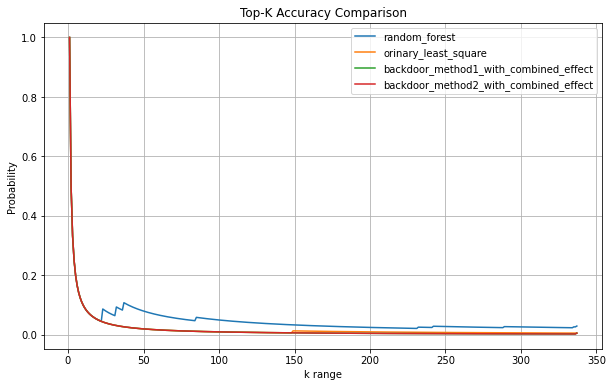

In [12]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison_pt2.png')

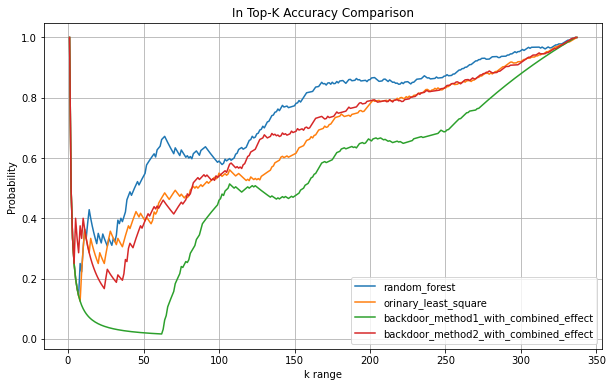

In [13]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("k range")
plt.ylabel("Probability")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison_pt2.png')
plt.show()

In [14]:
updated_df['true_row_index']=updated_df.index
rf_order['true_row_index']=rf_order.index
ols_order['true_row_index']=ols_order.index
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')
merged_df['true_row_index']=merged_df.index

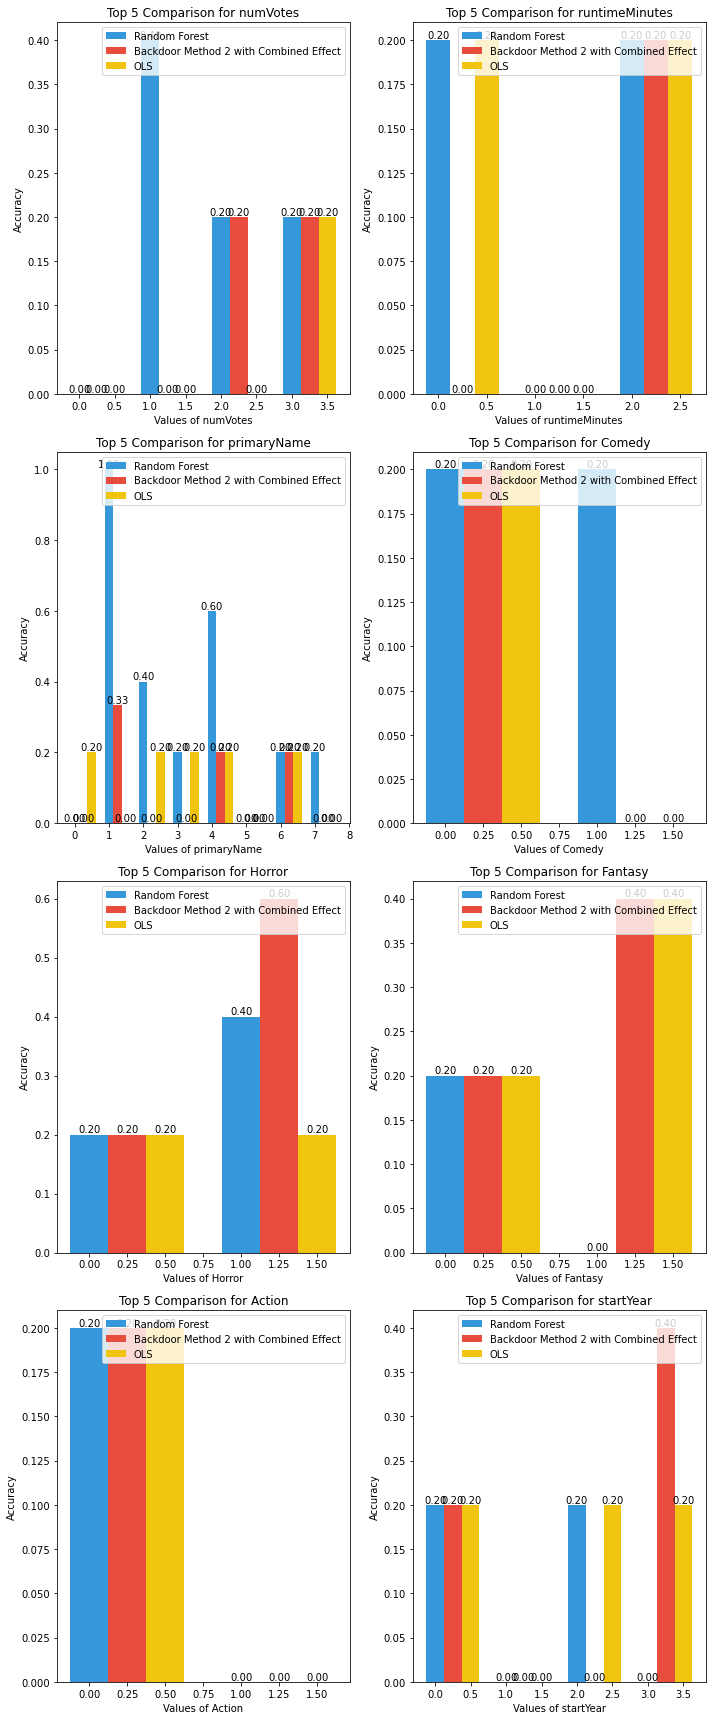

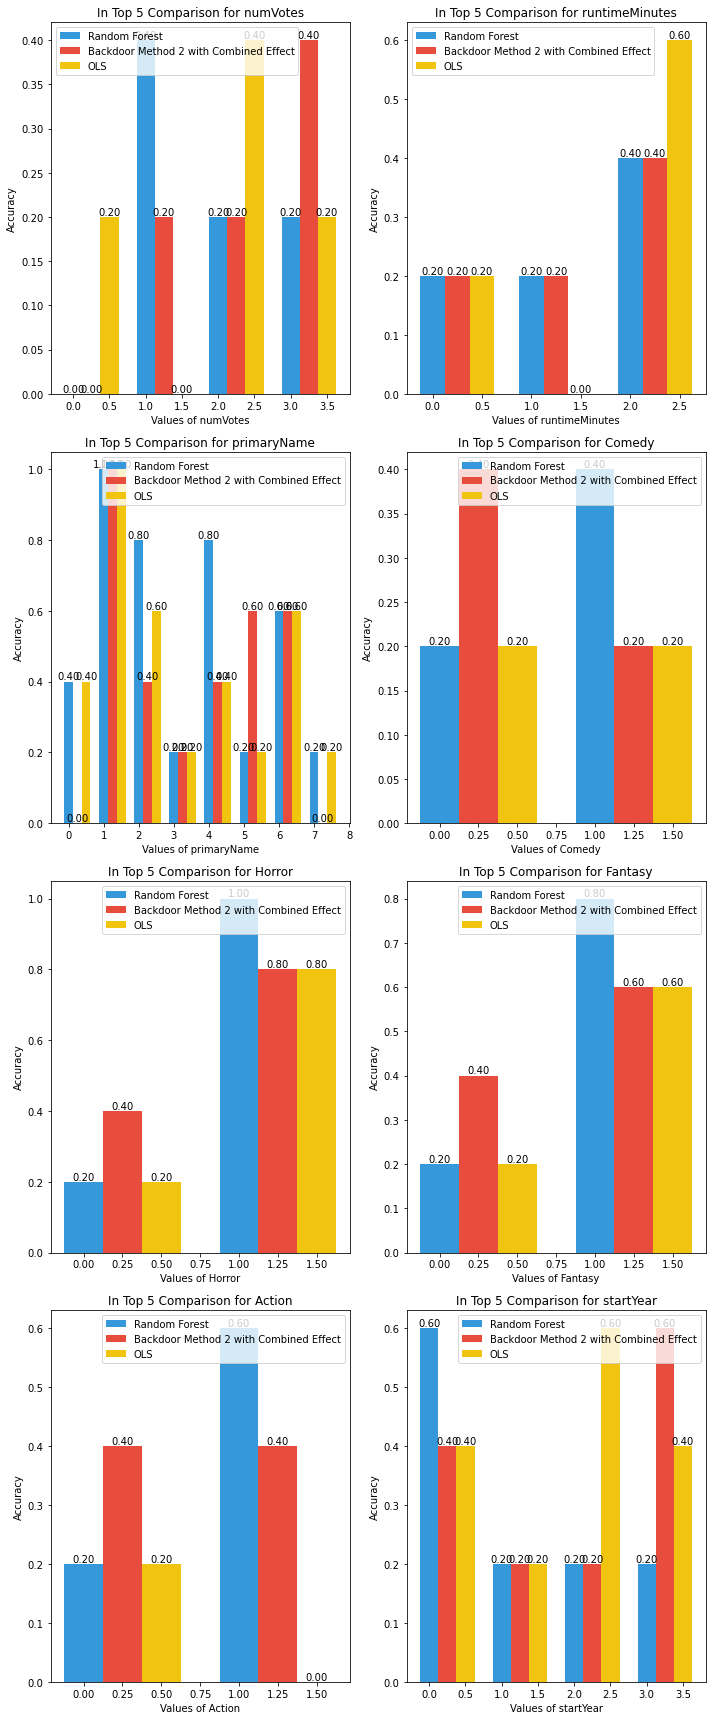

In [15]:
Xs = ["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]


plt.figure(figsize=(10, 3 * len(Xs)))

colors = {
    'random_forest': '#3498db', 
    'backdoor_method2_with_combined_effect': '#e74c3c', 
    'OLS': '#f1c40f' 
}


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest')
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Backdoor Method 2 with Combined Effect')
    bars3 = plt.bar(r3, df_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='OLS')
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')
            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_5_comparison_all_features_pt2.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest')
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Backdoor Method 2 with Combined Effect')
    bars3 = plt.bar(r3, df_in_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='OLS')
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')
            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 5 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_5_comparison_all_features_pt2.png')
plt.show()